In [4]:
!pip install  opencv-python matplotlib albumentations

  Using cached pydantic-2.10.6-py3-none-any.whl.metadata (30 kB)
  Using cached pydantic_core-2.27.2-cp312-cp312-win_amd64.whl.metadata (6.7 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached pydantic-2.10.6-py3-none-any.whl (431 kB)
Using cached pydantic_core-2.27.2-cp312-cp312-win_amd64.whl (2.0 MB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.11.0
    Uninstalling typing_extensions-4.11.0:
      Successfully uninstalled typing_extensions-4.11.0
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.20.1
    Uninstalling pydantic_core-2.20.1:
      Successfully uninstalled pydantic_core-2.20.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.8.2
    Uninstalling pydantic-2.8.2:
      Successfully uninstalled pydantic-2.8.2


In [10]:
import os
import time
import uuid
import cv2

In [14]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [18]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [109]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [117]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [33]:
images.as_numpy_iterator().next()

b'data\\images\\20250314_194425.jpg'

In [111]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [113]:
images = images.map(load_image)

In [119]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [145]:
image_generator = images.batch(4).as_numpy_iterator()

In [147]:
type(image_generator)

tensorflow.python.data.ops.dataset_ops.NumpyIterator

In [157]:
plot_images = image_generator.next()

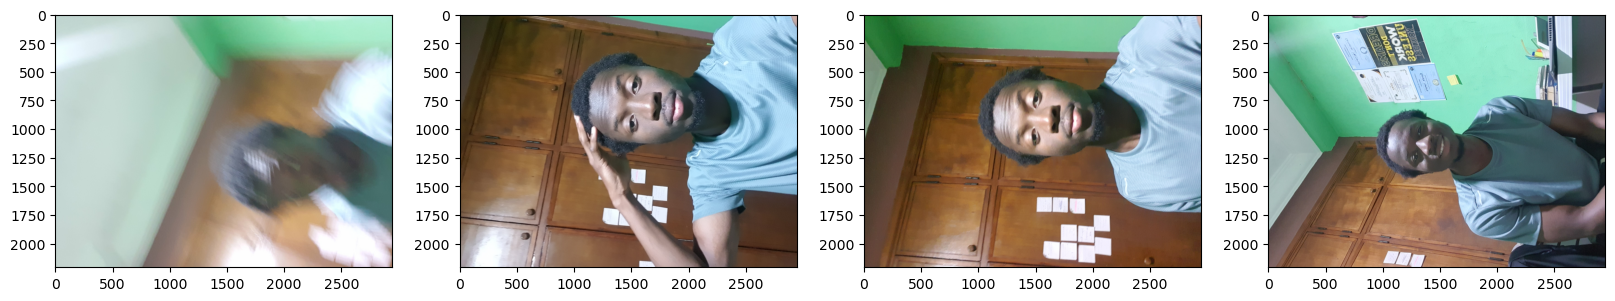

In [159]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [188]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

In [190]:
import albumentations as alb

In [308]:
augmentor = alb.Compose([alb.RandomCrop(width=700, height=700), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [227]:
img = cv2.imread(os.path.join('data','train', 'images','20250314_193925.jpg'))

In [281]:
img.shape

(1080, 1920, 3)

In [243]:
with open(os.path.join('data', 'train', 'labels', '20250314_193925.json'), 'r') as f:
    label = json.load(f)

In [257]:
label['shapes']

[{'label': 'face',
  'points': [[465.3636363636365, 1090.181818181818],
   [1633.5454545454545, 2503.8181818181815]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {},
  'mask': None}]

In [310]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [312]:
coords = list(np.divide(coords, [img.shape[1],img.shape[0],img.shape[1],img.shape[0]]))

In [314]:
coords

[0.3228236607142857, 0.3511904761904762, 0.5060453869047619, 0.779431216931217]

In [255]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [273]:
augmented['image'].shape

(450, 450, 3)

In [316]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [img.shape[1],img.shape[0],img.shape[1],img.shape[0]]))
            #print(coords)
        try: 
            for x in range(55):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                #print(image)
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                #print(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    print(label_path)
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json
data\train\labels\0000bee39176697a.json


In [318]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [322]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [324]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

In [329]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [331]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [333]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [335]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [345]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.7617, 0.61  , 1.    , 0.8594], dtype=float16))

In [347]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2365, 2365, 550, 550, 605, 605)

In [381]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.7617, 0.61  , 1.    , 0.8594], dtype=float16))

In [349]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [351]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [353]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [389]:
train.as_numpy_iterator().next()

(array([[[[0.73401415, 0.6006808 , 0.553622  ],
          [0.71772873, 0.5843954 , 0.5451797 ],
          [0.71116555, 0.58567536, 0.53469497],
          ...,
          [0.5256261 , 0.85111636, 0.67856735],
          [0.51805556, 0.8435458 , 0.6709967 ],
          [0.52415586, 0.84964603, 0.677097  ]],
 
         [[0.74052286, 0.60718954, 0.5601307 ],
          [0.7139706 , 0.5806373 , 0.5414216 ],
          [0.71331704, 0.58782685, 0.53684646],
          ...,
          [0.52344775, 0.8489379 , 0.6763889 ],
          [0.5240196 , 0.8495098 , 0.67696077],
          [0.52442783, 0.849918  , 0.677369  ]],
 
         [[0.7324074 , 0.59907407, 0.55201524],
          [0.7361928 , 0.6028595 , 0.5636438 ],
          [0.70974946, 0.5842593 , 0.5332789 ],
          ...,
          [0.53003806, 0.85552824, 0.6829792 ],
          [0.52230394, 0.8477941 , 0.6752451 ],
          [0.5318356 , 0.85732585, 0.68477684]],
 
         ...,
 
         [[0.11555023, 0.217511  , 0.22143257],
          [0.10457

In [365]:
data_samples = train.as_numpy_iterator()

In [453]:
res = data_samples.next()

In [425]:
type(res[0][0])

numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


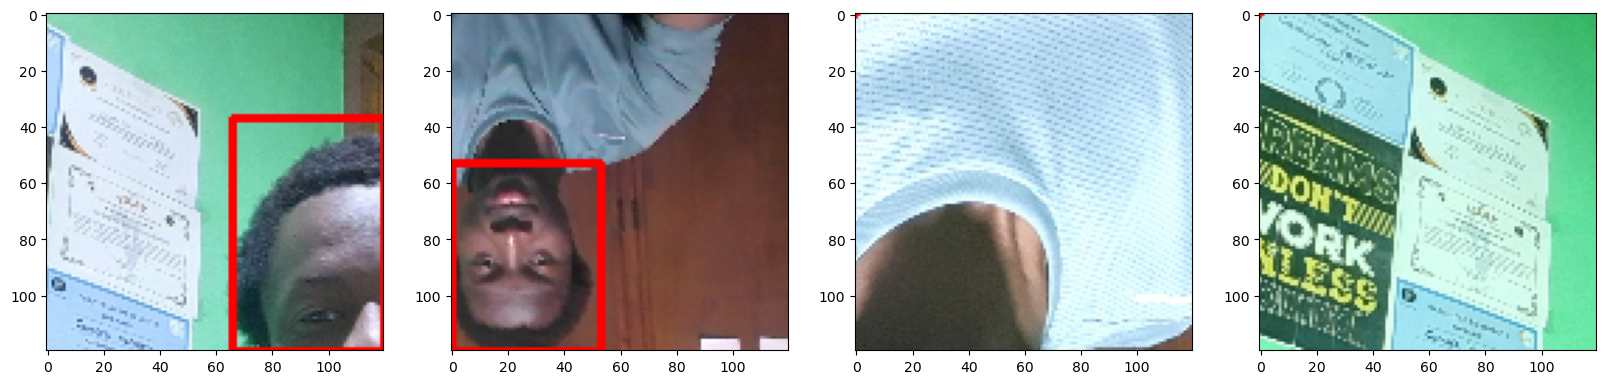

In [455]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_image = sample_image.copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [458]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [460]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


In [ ]:
vgg.summary()

In [465]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [468]:
facetracker = build_model()

In [470]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [472]:
X, y = train.as_numpy_iterator().next()

In [482]:
X.shape

(8, 120, 120, 3)

In [476]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


In [484]:
classes, coords

(array([[0.45083943],
        [0.43950385],
        [0.40399963],
        [0.44098684],
        [0.34009764],
        [0.40812424],
        [0.39403465],
        [0.4062556 ]], dtype=float32),
 array([[0.48361975, 0.3330552 , 0.61722255, 0.516057  ],
        [0.43430752, 0.2838698 , 0.6490794 , 0.47699836],
        [0.5873852 , 0.3567524 , 0.6164943 , 0.41200358],
        [0.49825853, 0.31960627, 0.61143583, 0.5331633 ],
        [0.46130112, 0.26903275, 0.7461343 , 0.47164145],
        [0.5323773 , 0.33762306, 0.6086786 , 0.5514486 ],
        [0.4322505 , 0.28293377, 0.6528324 , 0.4910579 ],
        [0.39328775, 0.33782962, 0.7005788 , 0.3774484 ]], dtype=float32))

In [486]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [488]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

C:\Users\pc\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
